## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on untrained data.
- Maintain good code quality.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset


from torch.optim import Adam

from torchvision.transforms.functional import to_tensor

import matplotlib.pyplot as plt






In [18]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True,)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False)

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


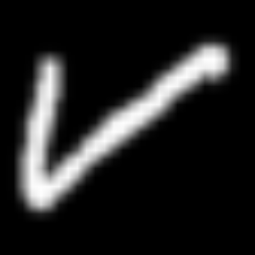

In [19]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

In [20]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transform)
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.1 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Training subset size: 69793
Test subset size: 11632


In [21]:
class NN1Layer(nn.Module):

  def __init__(self, num_inp, num_out):

    super(NN1Layer, self).__init__()

    self.layer_1 = nn.Linear(num_inp, num_out)
    #activation fun
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    z = self.layer_1(x)
    a = self.softmax(z)

    return a


class NN2Layer(nn.Module):

  def __init__(self, num_inp, num_hidden, num_out):

    super(NN2Layer, self).__init__()

    self.layer_1 = nn.Linear(num_inp, num_hidden)
    self.layer_2 = nn.Linear(num_hidden, num_out)

    self.hidden_activation = nn.ReLU()  # We can change the hidden activation (activation in between layer 1 and 2) here
    self.softmax = nn.Softmax(dim=1)  # dim 0 is normally batch size, we don't want to apply softmax across batch size

  def forward(self, x):

    z1 = self.layer_1(x)
    a1 = self.hidden_activation(z1)

    z2 = self.layer_2(a1)
    a2 = self.hidden_activation(z2)

    return a2

class NN3Layer(nn.Module):

  def __init__(self, num_inp, num_hidden, num_out):

    super(NN3Layer, self).__init__()

    self.layer_1 = nn.Linear(num_inp, num_hidden)
    self.layer_2 = nn.Linear(num_hidden, num_hidden)
    self.layer_3 = nn.Linear(num_hidden, num_out)

    self.hidden_activation = nn.ReLU()  # We can change the hidden activation (activation in between layer 1 and 2,3) here
    self.softmax = nn.Softmax(dim=1)  # dim 0

  def forward(self, x):

    z1 = self.layer_1(x)
    a1 = self.hidden_activation(z1)

    z2 = self.layer_2(a1)
    a2 = self.hidden_activation(z2)

    z3= self.layer_3(a2)
    a3 = self.softmax(z3)


    return a3

In [22]:
num_epochs = 15
lr = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_losses = []
val_losses = []

model = NN3Layer(28*28, 64, 62)  #  3 layer of NN with 64 neroun i try to improve the preformance
# reglization
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

Using device cpu


In [23]:
%%time
for epoch_no in range(num_epochs):

  model.train()

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.view(-1, 28*28).to(device)
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad() # clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)



  model.eval()
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients

    val_epoch_weighted_loss = 0
#off هنا ياخذها على كيفه ويشغلها
# on  هنا لاوم نوقفها
    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.view(-1, 28*28).to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

Epoch: 0, train_loss=3.880299918392949, val_loss=3.7530434698973267. labelled 4978/11632 correctly (42.79573590096286% accuracy)
Epoch: 1, train_loss=3.7195088324315133, val_loss=3.683065510845578. labelled 5627/11632 correctly (48.375171939477305% accuracy)
Epoch: 2, train_loss=3.6812919717719583, val_loss=3.6726927629363257. labelled 5691/11632 correctly (48.92537826685007% accuracy)
Epoch: 3, train_loss=3.67374722139767, val_loss=3.6694092681680126. labelled 5704/11632 correctly (49.037138927097665% accuracy)
Epoch: 4, train_loss=3.6695976886293153, val_loss=3.6648930362035026. labelled 5750/11632 correctly (49.43259972489684% accuracy)
Epoch: 5, train_loss=3.664910402856571, val_loss=3.6561675543962187. labelled 5857/11632 correctly (50.352475928473176% accuracy)
Epoch: 6, train_loss=3.655038017198588, val_loss=3.650426897418876. labelled 5925/11632 correctly (50.93707015130674% accuracy)
Epoch: 7, train_loss=3.6510643538935703, val_loss=3.646784938513167. labelled 5953/11632 corre

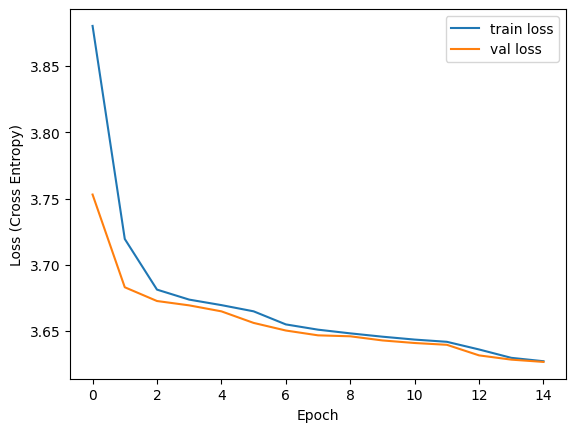

In [24]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()